### Importations

In [113]:
# Baisc Packages
import numpy as np
import pandas as pd
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings # ?
# Transformers
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
# Validation
from sklearn.model_selection import train_test_split
# model
import xgboost as xgb
# pipeline
from sklearn.pipeline import Pipeline
# validation
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import recall_score

In [2]:
# Intel Package for Acceleration
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Load Data

In [55]:
#Data path
train_transaction_path = "data/train_transaction.csv"
train_identity_path = "data/train_identity.csv"
test_transaction_path = "data/test_transaction.csv"
test_identity_path = "data/test_identity.csv"
sample_submission_path = "data/sample_submission.csv"

# Train Data Process
train_transaction = pd.read_csv(train_transaction_path)
train_identity = pd.read_csv(train_identity_path)
train_df = pd.merge(train_identity, train_transaction, on="TransactionID", how='right')
# Release Memory
del train_transaction
del train_identity

# Test Data Process
test_transaction = pd.read_csv(test_transaction_path)
test_identity = pd.read_csv(test_identity_path)
test_df = pd.merge(test_identity, test_transaction, on="TransactionID", how='right')
# Release Memory
del test_transaction
del test_identity

In [56]:
# make sure test_df and train_df are with the corresponding column names
test_df.columns = test_df.columns.str.replace('-', '_')

## Data Preprocessing

### Time

In [59]:
## Day of week (one hot)
def convert_day_of_week(x):
    return (x // (24 * 60 * 60)) % 7

# Hour of day (one hot)
def convert_hour(x):
    return (x // (1 * 60 * 60)) % 24

def addr1_transform(x):
    if x in top_addr1: 
        return x
    elif (pd.isnull(x) == True):
        return 0
    else:
        return -1
    
def addr2_transform(x):
    if x in top_addr2:
        return x
    elif (pd.isnull(x) == True):
        return 0
    else:
        return -1
    
def email_p_transform(x):
    if x in top_email_p:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'
    
def email_r_transform(x):
    if x in top_email_r:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'

In [60]:
# Transform the train_df
# Time
train_df['TransactionDT'] = train_df['TransactionDT'] - min(train_df['TransactionDT']) # shift encoding? might be in transformer, too
train_df['TransactionDayOfWeek'] = train_df['TransactionDT'].apply(convert_day_of_week) # give a day of week
train_df['TransactionHour'] = train_df['TransactionDT'].apply(convert_hour) # give the hour of the day

# Following utilize a Top K encoding for categorical variables
#addr1, addr2
top_addr1 = list(train_df['addr1'].value_counts().index)[:10] #top ten regions
top_addr2 = list(train_df['addr2'].value_counts().index)[:10] #top ten countries
train_df['addr1_new'] = train_df['addr1'].apply(addr1_transform)
train_df['addr2_new'] = train_df['addr2'].apply(addr2_transform)
#Email_Domain
top_email_p = list(train_df['P_emaildomain'].value_counts().index)[:20] #top twenty regions
top_email_r = list(train_df['R_emaildomain'].value_counts().index)[:20] #top twenty countries
train_df['P_emaildomain_new'] = train_df['P_emaildomain'].apply(email_p_transform)
train_df['R_emaildomain_new'] = train_df['R_emaildomain'].apply(email_r_transform)


In [61]:
# Transform the test_df
# Time
test_df['TransactionDT'] = test_df['TransactionDT'] - min(test_df['TransactionDT']) # shift encoding? might be in transformer, too
test_df['TransactionDayOfWeek'] = test_df['TransactionDT'].apply(convert_day_of_week) # give a day of week
test_df['TransactionHour'] = test_df['TransactionDT'].apply(convert_hour) # give the hour of the day

# Following utilize a Top K encoding for categorical variables
#addr1, addr2
top_addr1 = list(test_df['addr1'].value_counts().index)[:10] #top ten regions
top_addr2 = list(test_df['addr2'].value_counts().index)[:10] #top ten countries
test_df['addr1_new'] = test_df['addr1'].apply(addr1_transform)
test_df['addr2_new'] = test_df['addr2'].apply(addr2_transform)
#Email_Domain
top_email_p = list(test_df['P_emaildomain'].value_counts().index)[:20] #top twenty regions
top_email_r = list(test_df['R_emaildomain'].value_counts().index)[:20] #top twenty countries
test_df['P_emaildomain_new'] = test_df['P_emaildomain'].apply(email_p_transform)
test_df['R_emaildomain_new'] = test_df['R_emaildomain'].apply(email_r_transform)

To help memory efficiency, will directly show what is the formal train, test set:

X_train = train_df

y_train = train_df\['isFraud'\]

X_test = test_df

t_test is not known

## Pipeline and Model

In [62]:
train_df.shape

(590540, 440)

In [63]:
test_df.shape

(506691, 439)

In [79]:
one_hot_lst = ['DeviceType', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_32', 'id_34', 
               'id_35', 'id_36', 'id_37', 'id_38', 'TransactionDayOfWeek', 'TransactionHour', 'addr1_new', 'addr2_new',
                'ProductCD', 'card4', 'card6', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P_emaildomain_new', 'R_emaildomain_new']
identity_lst = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
                'dist1', 'dist2', 'TransactionDT'] + train_df.columns[train_df.columns.str.contains('V')].tolist() # V lists

In [80]:
preproc = ColumnTransformer(
    transformers = [
        ('ohe', OneHotEncoder(handle_unknown = 'ignore'), one_hot_lst),
        ('log', FunctionTransformer(np.log), ['TransactionAmt']),
        ('identity', FunctionTransformer(lambda x: x), identity_lst)
    ], remainder = 'drop'
)

In [81]:
# Pipeline
pl = Pipeline(steps = [
    ('preprocesser', preproc),
    ('xgb_cl', xgb.XGBClassifier(use_label_encoder =False))
])

In [87]:
%%time
# fit the train data
pl.fit(train_df.drop(columns='isFraud'), train_df['isFraud'])

C:\Users\keyuu\.conda\envs\intelai\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:38:39] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: total: 19min 45s
Wall time: 1min 53s


Pipeline(steps=[('preprocesser',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DeviceType', 'id_12',
                                                   'id_15', 'id_16', 'id_23',
                                                   'id_27', 'id_28', 'id_29',
                                                   'id_32', 'id_34', 'id_35',
                                                   'id_36', 'id_37', 'id_38',
                                                   'TransactionDayOfWeek',
                                                   'TransactionHour',
                                                   'addr1_new', 'addr2_new',
                                                   'ProductCD', 'card4',
                                                   'card6', 'M1', 'M2', 'M3',
                                                   'M4', 'M5'

## Pipeline & Model with Train Test Split

In [105]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(columns = 'isFraud'), train_df['isFraud'], test_size = 0.5, random_state=1)

In [106]:
# Pipeline cross_validated
pl_cv = Pipeline(steps = [
    ('preprocesser', preproc),
    ('xgb_cl', xgb.XGBClassifier(use_label_encoder = False))
])

In [107]:
%%time
# fit the train data
pl_cv.fit(X_train, y_train)

[01:55:44] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: total: 9min 50s
Wall time: 55.5 s


Pipeline(steps=[('preprocesser',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DeviceType', 'id_12',
                                                   'id_15', 'id_16', 'id_23',
                                                   'id_27', 'id_28', 'id_29',
                                                   'id_32', 'id_34', 'id_35',
                                                   'id_36', 'id_37', 'id_38',
                                                   'TransactionDayOfWeek',
                                                   'TransactionHour',
                                                   'addr1_new', 'addr2_new',
                                                   'ProductCD', 'card4',
                                                   'card6', 'M1', 'M2', 'M3',
                                                   'M4', 'M5'

In [108]:
# Accuracy on train data
pl_cv.score(X_train, y_train)

0.9822738510515799

In [109]:
# Accuracy on test data
pl_cv.score(X_test, y_test)

0.979523825651099

In [114]:
# Recall on test data
recall_score(y_test, pl_cv.predict(X_test))

0.4566890772678554

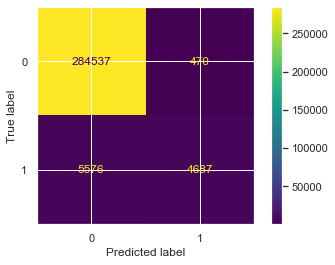

<Figure size 432x288 with 0 Axes>

In [110]:
# Confusion Matrix
plot_confusion_matrix(pl_cv, X_test, y_test)
plt.show()
plt.clf()

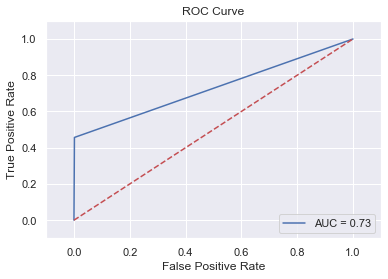

In [111]:
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, pl_cv.predict(X_test))
auc_score = auc(fpr, tpr)
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Evaluation

In [88]:
# Accuracy on train data
pl.score(train_df.drop(columns='isFraud'), train_df['isFraud'])

0.9817810817218139

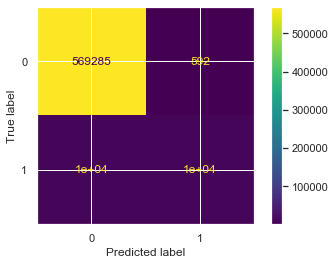

<Figure size 432x288 with 0 Axes>

In [89]:
# Confusion Matrix
plot_confusion_matrix(pl, train_df.drop(columns='isFraud'), train_df['isFraud'])
plt.show()
plt.clf()

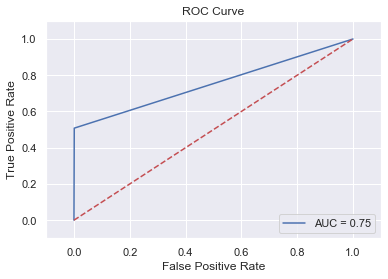

In [90]:
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(train_df['isFraud'], pl.predict(train_df.drop(columns='isFraud')))
auc_score = auc(fpr, tpr)
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Balanced Dataset

In [120]:
# create a balanced dataframe
train_is_fraud = train_df[train_df['isFraud']==1]
train_is_not_fraud = train_df[train_df['isFraud']==0].sample(n=len(train_is_fraud))
train_dfb = pd.concat([train_is_fraud, train_is_not_fraud])

# release memory
del train_is_fraud
del train_is_not_fraud

In [121]:
X_train, X_test, y_train, y_test = train_test_split(train_dfb.drop(columns = 'isFraud'), train_dfb['isFraud'], random_state=1)

In [122]:
# Pipeline cross validated balanced
pl_cvb = Pipeline(steps = [
    ('preprocesser', preproc),
    ('xgb_cl', xgb.XGBClassifier(use_label_encoder = False))
])

In [124]:
%%time
# fit the train data
pl_cvb.fit(X_train, y_train)

[02:13:01] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: total: 1min 4s
Wall time: 5.94 s


Pipeline(steps=[('preprocesser',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DeviceType', 'id_12',
                                                   'id_15', 'id_16', 'id_23',
                                                   'id_27', 'id_28', 'id_29',
                                                   'id_32', 'id_34', 'id_35',
                                                   'id_36', 'id_37', 'id_38',
                                                   'TransactionDayOfWeek',
                                                   'TransactionHour',
                                                   'addr1_new', 'addr2_new',
                                                   'ProductCD', 'card4',
                                                   'card6', 'M1', 'M2', 'M3',
                                                   'M4', 'M5'

In [125]:
# Accuracy on train data
pl_cvb.score(X_train, y_train)

0.9093372910885978

In [126]:
# Accuracy on test data
pl_cvb.score(X_test, y_test)

0.8465931087882307

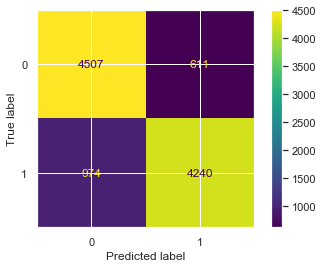

<Figure size 432x288 with 0 Axes>

In [127]:
# Confusion Matrix
plot_confusion_matrix(pl_cvb, X_test, y_test)
plt.show()
plt.clf()

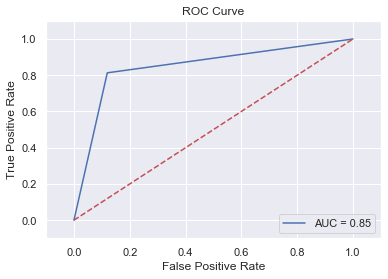

In [128]:
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, pl_cvb.predict(X_test))
auc_score = auc(fpr, tpr)
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [129]:
# following is a for balanced model output
submission = pd.DataFrame({'TransactionID': test_df['TransactionID'], 'isFraud': pl_cvb.predict(test_df)})
submission.to_csv("modified_submission_vb.csv", index = False)